# Fusion
### Bottle

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, models
# from torchvision.datasets import VOCDetection
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# import numpy as np
# import os
# import gc
# from torchvision.models import vit_b_16, ViT_B_16_Weights, resnet50, ResNet50_Weights, vgg19_bn, VGG19_BN_Weights

# # Setup device and directories
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.makedirs('saved_models', exist_ok=True)

# # Free up memory
# torch.cuda.empty_cache()
# gc.collect()

# class VOCBottleClassification(Dataset):
#     def __init__(self, root, year, image_set, transform=None):
#         self.voc = VOCDetection(root=root, year=year, image_set=image_set, download=True,
#                               transforms=lambda img, target: (transform(img), target))
#         self.transform = transform

#     def __len__(self):
#         return len(self.voc)

#     def __getitem__(self, idx):
#         img, target = self.voc[idx]
#         objs = target['annotation']['object']
#         if not isinstance(objs, list):
#             objs = [objs]
#         label = 1 if any(o['name'] == 'bottle' for o in objs) else 0
#         img_id = target['annotation']['filename']
#         return img, label, img_id

# class BinaryFocalLoss(nn.Module):
#     def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
#         super().__init__()
#         self.gamma = gamma
#         self.alpha = alpha
#         self.reduction = reduction
#         self.bce = nn.BCEWithLogitsLoss(reduction='none')

#     def forward(self, inputs, targets):
#         BCE_loss = self.bce(inputs, targets)
#         probs = torch.sigmoid(inputs)
#         pt = torch.where(targets == 1, probs, 1 - probs)
#         focal_term = (1 - pt) ** self.gamma
#         loss = self.alpha * focal_term * BCE_loss
#         return loss.mean() if self.reduction == 'mean' else loss

# class FeatureExtractor(nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#         if isinstance(model, torchvision.models.VisionTransformer):
#             self.features = model.encoder
#         elif isinstance(model, torchvision.models.ResNet):
#             self.features = nn.Sequential(*list(model.children())[:-1])
#         elif isinstance(model, torchvision.models.VGG):
#             self.features = model.features
#             self.pool = nn.AdaptiveAvgPool2d((1, 1))
#             self.flatten = nn.Flatten()

#     def forward(self, x):
#         if isinstance(self.model, torchvision.models.VisionTransformer):
#             x = self.model._process_input(x)
#             batch_class_token = self.model.class_token.expand(x.shape[0], -1, -1)
#             x = torch.cat([batch_class_token, x], dim=1)
#             x = self.features(x)
#             return x[:, 0]
#         elif isinstance(self.model, torchvision.models.ResNet):
#             features = self.features(x)
#             return torch.flatten(features, 1)
#         elif isinstance(self.model, torchvision.models.VGG):
#             features = self.features(x)
#             pooled = self.pool(features)
#             return self.flatten(pooled)

# def save_model(model, model_idx):
#     torch.save(model.state_dict(), f'saved_models/model_{model_idx}_full.pth')
#     print(f"Saved model {model_idx}")

# # Transforms
# transform_train = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# transform_val = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Data Loaders
# train_ds = VOCBottleClassification(root='.', year='2008', image_set='train', transform=transform_train)
# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=min(2, os.cpu_count() // 2))

In [ ]:
# # Models to train
# models_to_train = [
#     {'model': 'ViT_B_16', 'epochs': 5, 'weights': ViT_B_16_Weights.IMAGENET1K_V1},
#     {'model': 'ResNet50', 'epochs': 10, 'weights': ResNet50_Weights.IMAGENET1K_V1},
#     {'model': 'VGG19_BN', 'epochs': 5, 'weights': VGG19_BN_Weights.IMAGENET1K_V1}
# ]

# # Training loop
# for model_idx, config in enumerate(models_to_train):
#     print(f"\nTraining {config['model']} (Model {model_idx+1}/{len(models_to_train)})")

#     # Initialize model
#     if config['model'] == 'ViT_B_16':
#         model = vit_b_16(weights=config['weights'])
#         model.heads.head = nn.Linear(model.heads.head.in_features, 1)
#     elif config['model'] == 'ResNet50':
#         model = resnet50(weights=config['weights'])
#         model.fc = nn.Linear(model.fc.in_features, 1)
#     elif config['model'] == 'VGG19_BN':
#         model = vgg19_bn(weights=config['weights'])
#         model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)

#     model = model.to(device)
#     criterion = BinaryFocalLoss()
#     optimizer = optim.AdamW(model.parameters(), lr=3e-5)
#     scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

#     # Training epochs
#     for epoch in range(config['epochs']):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}"):
#             inputs, labels = inputs.to(device), labels.float().to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs).squeeze(1)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         scheduler.step()
#         print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

#     # Save the trained model
#     save_model(model, model_idx)

# print("\nTraining completed! Models saved to 'saved_models' directory.")


Training ViT_B_16 (Model 1/3)


Epoch 1/1: 100%|██████████| 66/66 [01:17<00:00,  1.18s/it]


Epoch 1, Loss: 0.0168
Saved model 0

Training ResNet50 (Model 2/3)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]
Epoch 1/1: 100%|██████████| 66/66 [00:23<00:00,  2.83it/s]


Epoch 1, Loss: 0.0200
Saved model 1

Training VGG19_BN (Model 3/3)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:05<00:00, 99.3MB/s]
Epoch 1/1: 100%|██████████| 66/66 [00:46<00:00,  1.41it/s]


Epoch 1, Loss: 0.0182
Saved model 2

Training completed! Models saved to 'saved_models' directory.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import VOCDetection
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import torchvision
from torchvision.models import vit_b_16, ViT_B_16_Weights, resnet50, ResNet50_Weights, vgg19_bn, VGG19_BN_Weights

# Setup device and directories
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs('saved_models', exist_ok=True)

# Free up memory
torch.cuda.empty_cache()
gc.collect()

class VOCBottleClassification(Dataset):
    def __init__(self, root, year, image_set, transform=None):
        self.voc = VOCDetection(root=root, year=year, image_set=image_set, download=True,
                              transforms=lambda img, target: (transform(img), target))
        self.transform = transform

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        img, target = self.voc[idx]
        objs = target['annotation']['object']
        if not isinstance(objs, list):
            objs = [objs]
        label = 1 if any(o['name'] == 'bottle' for o in objs) else 0
        img_id = target['annotation']['filename']
        return img, label, img_id

class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * BCE_loss
        return loss.mean() if self.reduction == 'mean' else loss

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        # Handle different model architectures
        if isinstance(model, torchvision.models.VisionTransformer):
            # For ViT, we'll use the encoder's output
            self.features = model.encoder
        elif isinstance(model, torchvision.models.ResNet):
            # For ResNet, use everything except the final fc layer
            self.features = nn.Sequential(*list(model.children())[:-1])
        elif isinstance(model, torchvision.models.VGG):
            # For VGG, use the features part
            self.features = model.features
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
            self.flatten = nn.Flatten()

    def forward(self, x):
        if isinstance(self.model, torchvision.models.VisionTransformer):
            # ViT expects (batch, seq_len, hidden_dim)
            x = self.model._process_input(x)
            batch_class_token = self.model.class_token.expand(x.shape[0], -1, -1)
            x = torch.cat([batch_class_token, x], dim=1)
            x = self.features(x)
            return x[:, 0]  # Return class token
        elif isinstance(self.model, torchvision.models.ResNet):
            features = self.features(x)
            return torch.flatten(features, 1)
        elif isinstance(self.model, torchvision.models.VGG):
            features = self.features(x)
            pooled = self.pool(features)
            return self.flatten(pooled)

class EarlyFusionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.fc(x)

def save_model(model, model_name):
    """Save the full model"""
    torch.save(model.state_dict(), f'saved_models/{model_name}.pth')
    print(f"Saved model {model_name}")

def load_models():
    models = []
    feature_extractors = []
    model_configs = [
        {'type': 'vit', 'weights': ViT_B_16_Weights.IMAGENET1K_V1},
        {'type': 'resnet', 'weights': ResNet50_Weights.IMAGENET1K_V1},
        {'type': 'vgg', 'weights': VGG19_BN_Weights.IMAGENET1K_V1}
    ]

    for i, config in enumerate(model_configs):
        # Initialize model
        if config['type'] == 'vit':
            model = vit_b_16(weights=None)
            model.heads.head = nn.Linear(model.heads.head.in_features, 1)
        elif config['type'] == 'resnet':
            model = resnet50(weights=None)
            model.fc = nn.Linear(model.fc.in_features, 1)
        elif config['type'] == 'vgg':
            model = vgg19_bn(weights=None)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)

        # Load model state dict
        model.load_state_dict(torch.load(f'saved_models/model_{i}_full.pth'))
        model = model.to(device).eval()

        # Create feature extractor from loaded model
        fe = FeatureExtractor(model).to(device).eval()

        models.append(model)
        feature_extractors.append(fe)

    return models, feature_extractors

def extract_features_and_predictions(loader, feature_extractors, models):
    all_features = [[] for _ in feature_extractors]
    all_predictions = [[] for _ in models]
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in tqdm(loader):
            inputs = inputs.to(device)
            for i, (fe, model) in enumerate(zip(feature_extractors, models)):
                features = fe(inputs)
                preds = torch.sigmoid(model(inputs)).squeeze(1).cpu()
                all_features[i].append(features.cpu())
                all_predictions[i].append(preds)
            all_labels.append(labels)

    return [torch.cat(f, dim=0) for f in all_features], [torch.cat(p, dim=0) for p in all_predictions], torch.cat(all_labels, dim=0)

def majority_vote(preds, threshold=0.5):
    binary_preds = (preds > threshold).astype(int)
    return (np.mean(binary_preds, axis=1) > 0.5).astype(int)

def average_fusion(preds): return np.mean(preds, axis=1)
def max_fusion(preds): return np.max(preds, axis=1)
def min_fusion(preds): return np.min(preds, axis=1)

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loaders - only train set
train_ds = VOCBottleClassification(root='.', year='2008', image_set='train', transform=transform_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=min(2, os.cpu_count() // 2))

# Only run this block if you need to train models from scratch
models_to_train = [
    {'model': 'ViT_B_16', 'epochs': 1, 'weights': ViT_B_16_Weights.IMAGENET1K_V1},
    {'model': 'ResNet50', 'epochs': 1, 'weights': ResNet50_Weights.IMAGENET1K_V1},
    {'model': 'VGG19_BN', 'epochs': 1, 'weights': VGG19_BN_Weights.IMAGENET1K_V1}
]

for model_idx, config in enumerate(models_to_train):
    print(f"\nTraining {config['model']} (Model {model_idx+1}/{len(models_to_train)})")

    if config['model'] == 'ViT_B_16':
        model = vit_b_16(weights=config['weights'])
        model.heads.head = nn.Linear(model.heads.head.in_features, 1)
    elif config['model'] == 'ResNet50':
        model = resnet50(weights=config['weights'])
        model.fc = nn.Linear(model.fc.in_features, 1)
    elif config['model'] == 'VGG19_BN':
        model = vgg19_bn(weights=config['weights'])
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)

    model = model.to(device)
    criterion = BinaryFocalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

    for epoch in range(config['epochs']):
        model.train()
        running_loss = 0.0
        for inputs, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}"):
            inputs, labels = inputs.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    save_model(model, f"model_{model_idx}_full")

# Load models and extract features
print("\nLoading models for fusion...")
models, feature_extractors = load_models()
train_features, train_preds, train_labels = extract_features_and_predictions(train_loader, feature_extractors, models)

# Early Fusion - Train on training data
print("\nTraining Early Fusion models...")
X_train_early = torch.cat(train_features, dim=1).numpy()
y_train = train_labels.numpy()

# Train a StandardScaler and save it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_early_scaled = scaler.fit_transform(X_train_early)
np.save('saved_models/scaler_mean.npy', scaler.mean_)
np.save('saved_models/scaler_scale.npy', scaler.scale_)
print("Scaler parameters saved")

# Train RBF SVM and save
from sklearn.svm import SVC
import pickle
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_early_scaled, y_train)
with open('saved_models/early_fusion_svm.pkl', 'wb') as f:
    pickle.dump(svm, f)
print("Early Fusion SVM model saved")

# Train Neural Network and save
early_nn = EarlyFusionNN(X_train_early.shape[1]).to(device)
optimizer = optim.Adam(early_nn.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

X_train_tensor = torch.FloatTensor(X_train_early_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)

for epoch in range(1):
    early_nn.train()
    optimizer.zero_grad()
    outputs = early_nn(X_train_tensor).squeeze(1)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Early Fusion NN Epoch {epoch+1}, Loss: {loss.item():.4f}")

save_model(early_nn, "early_fusion_nn")

# Late Fusion Models - Save functions for use during inference
train_preds_np = [p.numpy() for p in train_preds]
train_preds_stack = np.stack(train_preds_np, axis=1)

# Save the base model predictions for future reference
np.save('saved_models/base_model_train_preds.npy', train_preds_stack)

print("\nFusion models trained and saved successfully!")


Training ViT_B_16 (Model 1/3)


Epoch 1/1: 100%|██████████| 66/66 [01:17<00:00,  1.18s/it]


Epoch 1, Loss: 0.0161
Saved model model_0_full

Training ResNet50 (Model 2/3)


Epoch 1/1: 100%|██████████| 66/66 [00:23<00:00,  2.82it/s]


Epoch 1, Loss: 0.0281
Saved model model_1_full

Training VGG19_BN (Model 3/3)


Epoch 1/1: 100%|██████████| 66/66 [00:46<00:00,  1.43it/s]


Epoch 1, Loss: 0.0173
Saved model model_2_full

Loading models for fusion...


100%|██████████| 66/66 [01:32<00:00,  1.40s/it]



Training Early Fusion models...
Scaler parameters saved
Early Fusion SVM model saved
Early Fusion NN Epoch 1, Loss: 0.7167
Saved model early_fusion_nn

Fusion models trained and saved successfully!


Loading models...
Extracting images from /content/test.zip...
Processing 3499 images...
Applying early fusion models...
Applying late fusion methods...


<ipython-input-16-9a6af0565751>:257: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Visualization saved as 'top_predictions.png'


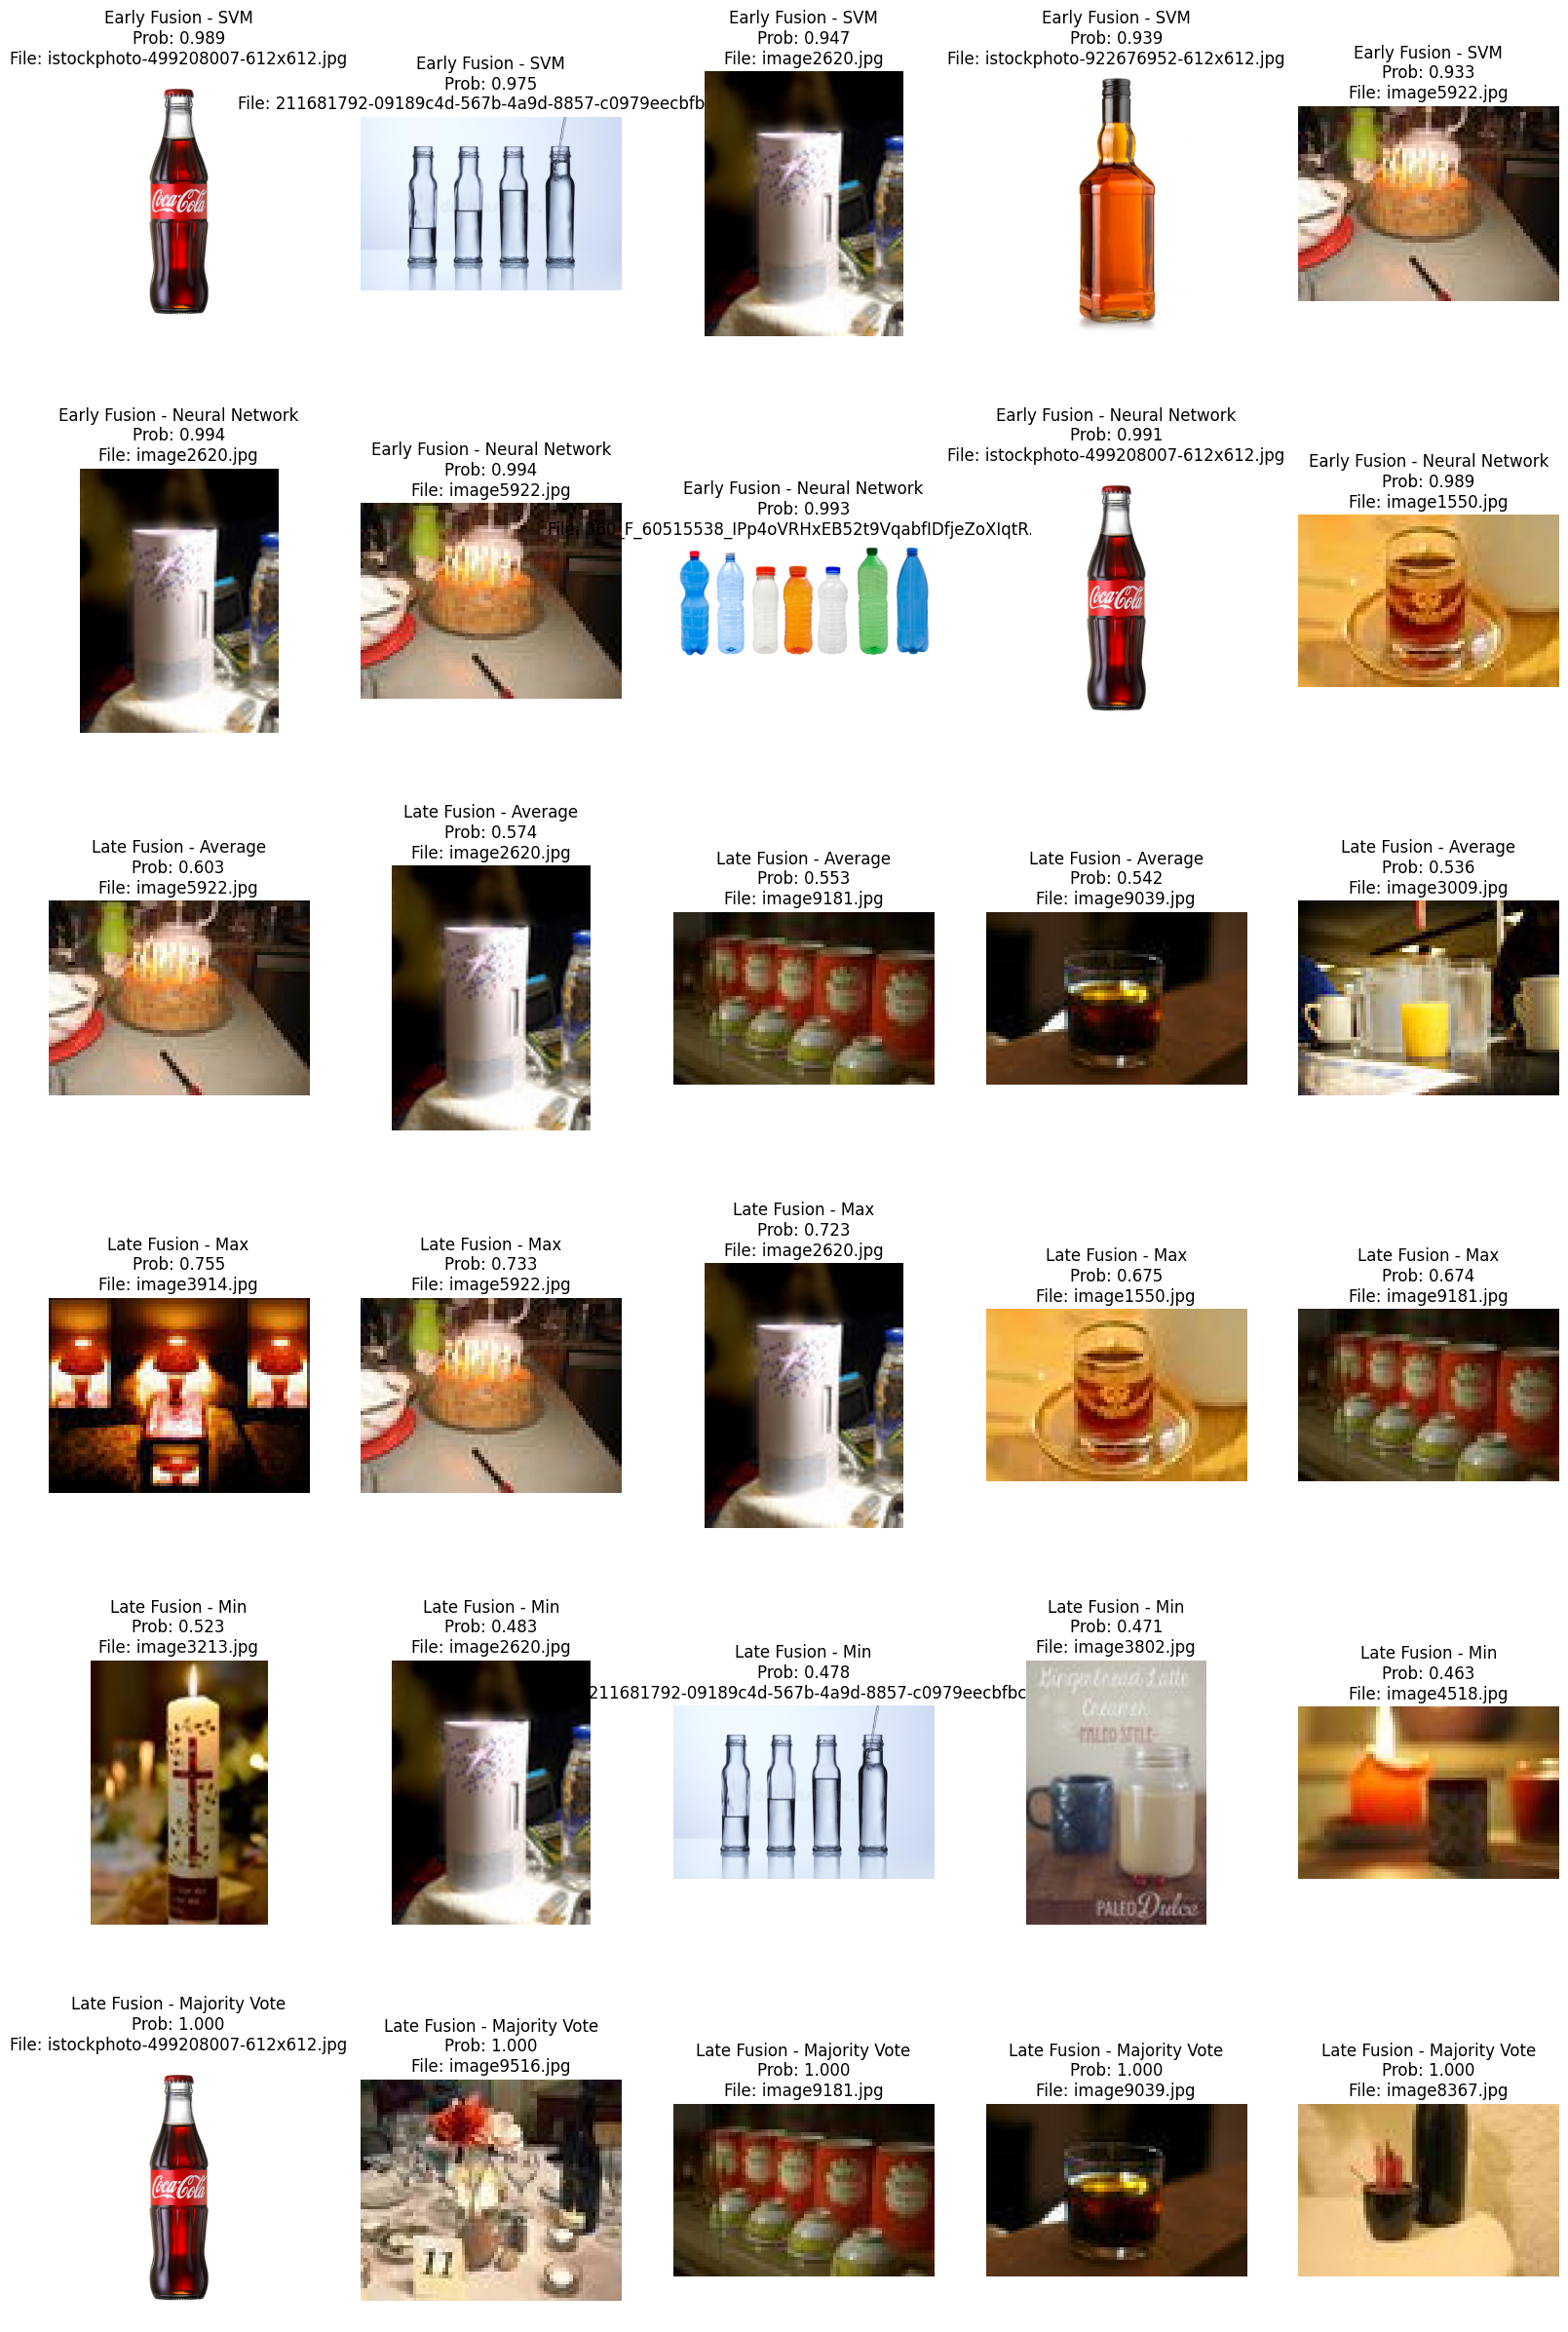


Summary Statistics:

Early Fusion Models:
  SVM: 60 images classified as 'bottle' (threshold=0.5)
  Neural Network: 1345 images classified as 'bottle' (threshold=0.5)

Late Fusion Models:
  Average: 19 images classified as 'bottle' (threshold=0.5)
  Max: 120 images classified as 'bottle' (threshold=0.5)
  Min: 1 images classified as 'bottle' (threshold=0.5)
  Majority Vote: 14 images classified as 'bottle' (threshold=0.5)


In [ ]:
import torch
import numpy as np
import os
import zipfile
import io
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import pickle
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torchvision.models import vit_b_16, resnet50, vgg19_bn
import torchvision

# Utility functions and classes
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        # Handle different model architectures
        if isinstance(model, torchvision.models.VisionTransformer):
            # For ViT, we'll use the encoder's output
            self.features = model.encoder
        elif isinstance(model, torchvision.models.ResNet):
            # For ResNet, use everything except the final fc layer
            self.features = nn.Sequential(*list(model.children())[:-1])
        elif isinstance(model, torchvision.models.VGG):
            # For VGG, use the features part
            self.features = model.features
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
            self.flatten = nn.Flatten()

    def forward(self, x):
        if isinstance(self.model, torchvision.models.VisionTransformer):
            # ViT expects (batch, seq_len, hidden_dim)
            x = self.model._process_input(x)
            batch_class_token = self.model.class_token.expand(x.shape[0], -1, -1)
            x = torch.cat([batch_class_token, x], dim=1)
            x = self.features(x)
            return x[:, 0]  # Return class token
        elif isinstance(self.model, torchvision.models.ResNet):
            features = self.features(x)
            return torch.flatten(features, 1)
        elif isinstance(self.model, torchvision.models.VGG):
            features = self.features(x)
            pooled = self.pool(features)
            return self.flatten(pooled)

class EarlyFusionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.fc(x)

def load_base_models():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    models = []
    feature_extractors = []

    # Initialize ViT model
    vit_model = vit_b_16(weights=None)
    vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 1)
    vit_model.load_state_dict(torch.load('saved_models/model_0_full.pth', map_location=device))
    vit_model = vit_model.to(device).eval()
    models.append(vit_model)
    feature_extractors.append(FeatureExtractor(vit_model).to(device).eval())

    # Initialize ResNet model
    resnet_model = resnet50(weights=None)
    resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 1)
    resnet_model.load_state_dict(torch.load('saved_models/model_1_full.pth', map_location=device))
    resnet_model = resnet_model.to(device).eval()
    models.append(resnet_model)
    feature_extractors.append(FeatureExtractor(resnet_model).to(device).eval())

    # Initialize VGG model
    vgg_model = vgg19_bn(weights=None)
    vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, 1)
    vgg_model.load_state_dict(torch.load('saved_models/model_2_full.pth', map_location=device))
    vgg_model = vgg_model.to(device).eval()
    models.append(vgg_model)
    feature_extractors.append(FeatureExtractor(vgg_model).to(device).eval())

    return models, feature_extractors

def load_fusion_models():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load scaler
    scaler_mean = np.load('saved_models/scaler_mean.npy')
    scaler_scale = np.load('saved_models/scaler_scale.npy')
    scaler = StandardScaler()
    scaler.mean_ = scaler_mean
    scaler.scale_ = scaler_scale

    # Load SVM
    with open('saved_models/early_fusion_svm.pkl', 'rb') as f:
        svm = pickle.load(f)

    # Load NN
    # Get feature dimension from scaler mean shape
    feature_dim = scaler_mean.shape[0]
    early_nn = EarlyFusionNN(feature_dim).to(device)
    early_nn.load_state_dict(torch.load('saved_models/early_fusion_nn.pth', map_location=device))
    early_nn.eval()

    return scaler, svm, early_nn

def average_fusion(preds):
    return np.mean(preds, axis=1)

def max_fusion(preds):
    return np.max(preds, axis=1)

def min_fusion(preds):
    return np.min(preds, axis=1)

def majority_vote(preds, threshold=0.5):
    binary_preds = (preds > threshold).astype(int)
    return (np.mean(binary_preds, axis=1) > 0.5).astype(int)

def process_zip_images(zip_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load models
    print("Loading models...")
    base_models, feature_extractors = load_base_models()
    scaler, svm, early_nn = load_fusion_models()

    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Extract images from zip
    print(f"Extracting images from {zip_path}...")
    images = []
    original_images = []
    image_paths = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                with zip_ref.open(file_info) as file:
                    img_data = file.read()
                    img = Image.open(io.BytesIO(img_data)).convert('RGB')
                    original_images.append(img.copy())
                    images.append(transform(img))
                    image_paths.append(file_info.filename)

    # If no images were found
    if not images:
        print("No images found in the zip file.")
        return

    # Process images in batches
    print(f"Processing {len(images)} images...")
    batch_size = 16
    all_features = [[] for _ in feature_extractors]
    all_predictions = [[] for _ in base_models]

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch_tensor = torch.stack(batch).to(device)

            # Process with each model
            for j, (model, fe) in enumerate(zip(base_models, feature_extractors)):
                # Get predictions from base model
                preds = torch.sigmoid(model(batch_tensor)).squeeze(1).cpu().numpy()
                all_predictions[j].extend(preds)

                # Extract features
                features = fe(batch_tensor).cpu().numpy()
                all_features[j].extend(features)

    # Convert lists to arrays
    all_features = [np.array(f) for f in all_features]
    all_predictions = [np.array(p) for p in all_predictions]

    # Early fusion
    print("Applying early fusion models...")
    X_early = np.concatenate([f for f in all_features], axis=1)
    X_early_scaled = scaler.transform(X_early)

    # SVM predictions
    early_svm_probs = svm.predict_proba(X_early_scaled)[:, 1]

    # NN predictions
    X_early_tensor = torch.FloatTensor(X_early_scaled).to(device)
    with torch.no_grad():
        early_nn_probs = torch.sigmoid(early_nn(X_early_tensor)).squeeze().cpu().numpy()

    # Late fusion
    print("Applying late fusion methods...")
    predictions_stack = np.stack(all_predictions, axis=1)

    late_fusion_results = {
        'Average': average_fusion(predictions_stack),
        'Max': max_fusion(predictions_stack),
        'Min': min_fusion(predictions_stack),
        'Majority Vote': majority_vote(predictions_stack)
    }

    early_fusion_results = {
        'SVM': early_svm_probs,
        'Neural Network': early_nn_probs
    }

    # Return all results and images
    return {
        'early_fusion': early_fusion_results,
        'late_fusion': late_fusion_results,
        'images': original_images,
        'paths': image_paths,
        'base_predictions': all_predictions
    }

def display_top_predictions(results, top_n=5):
    # Create a figure to display results
    fig, axes = plt.subplots(len(results['early_fusion']) + len(results['late_fusion']),
                            top_n, figsize=(20, 5*len(results['early_fusion']) + 5*len(results['late_fusion'])),
                            gridspec_kw={'hspace': 0.5})

    # Helper function to plot a row of predictions
    def plot_prediction_row(row_idx, method_name, probs):
        # Get indices of top predictions
        top_indices = np.argsort(-probs)[:top_n]

        for col_idx, img_idx in enumerate(top_indices):
            ax = axes[row_idx, col_idx]
            ax.imshow(results['images'][img_idx])
            ax.set_title(f"{method_name}\nProb: {probs[img_idx]:.3f}\nFile: {os.path.basename(results['paths'][img_idx])}")
            ax.axis('off')

    # Plot early fusion results
    row = 0
    for method, probs in results['early_fusion'].items():
        plot_prediction_row(row, f"Early Fusion - {method}", probs)
        row += 1

    # Plot late fusion results
    for method, probs in results['late_fusion'].items():
        plot_prediction_row(row, f"Late Fusion - {method}", probs)
        row += 1

    plt.tight_layout()
    plt.savefig('top_predictions.png', dpi=150, bbox_inches='tight')
    print("Visualization saved as 'top_predictions.png'")
    plt.show()

def main(zip_path):
    # Process the zip file
    results = process_zip_images('/content/test.zip')

    if results:
        # Display top predictions
        display_top_predictions(results)

        # Print summary statistics
        print("\nSummary Statistics:")
        print("\nEarly Fusion Models:")
        for method, probs in results['early_fusion'].items():
            total_positives = np.sum(probs > 0.5)
            print(f"  {method}: {total_positives} images classified as 'bottle' (threshold=0.5)")

        print("\nLate Fusion Models:")
        for method, probs in results['late_fusion'].items():
            total_positives = np.sum(probs > 0.5)
            print(f"  {method}: {total_positives} images classified as 'bottle' (threshold=0.5)")
    else:
        print("No results to display.")

if __name__ == "__main__":
    # Replace 'test_images.zip' with your actual zip file path
    zip_path = 'test_images.zip'
    main(zip_path)